## Eigen Analysis

### Import & Load
***

In [1]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

root = os.environ['HOME']+"/private/pca-yield-curve-analytics/"
sys.path.append(root)

from src.pca import PCA
from src.utils import calc_rmse, std_scale_pandas, rainbow

In [2]:
plt.rcParams.update({'font.size': 8})

In [3]:
df       = pd.read_csv("../assets/rates_clean.csv", index_col="DATE", parse_dates=["DATE"])
df_train = pd.read_csv("../assets/train.csv", index_col="DATE", parse_dates=["DATE"])
df_test  = pd.read_csv("../assets/test.csv", index_col="DATE", parse_dates=["DATE"])

pca_train = joblib.load("../assets/pca_train.joblib")
pca_full = joblib.load("../assets/pca_full.joblib")

pca_full.__dict__.keys()

dict_keys(['maturities', 'components', 'k', 'cov', 'eig_values', 'eig_vectors', 'eig_vectors_inverse', 'eig_scores', 'backtrans_rates'])

In [4]:
eig_vectors   = pca_full.eig_vectors.iloc[:, :pca_full.k]
eig_values    = pca_full.eig_values
eig_scores    = pca_full.eig_scores.iloc[:, :pca_full.k]
pca_rates     = pca_full.backtrans_rates
components    = pca_full.components[:pca_full.k]

### Eigen Vectors & Values
***

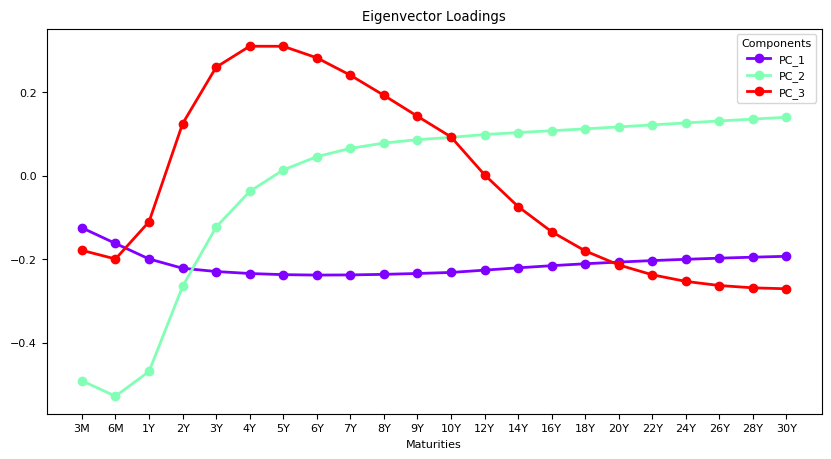

In [5]:
fig, ax = plt.subplots(figsize=(10,5))
color = rainbow(np.linspace(0,1,3)).values()

for (name, val), c in zip(eig_vectors.items(), color):
    ax.plot(val, c=c, label=name, linewidth=2, marker="o")

ax.set_title ("Eigenvector Loadings")
ax.set_xlabel ("Maturities")
ax.legend(title="Components")

plt.show()

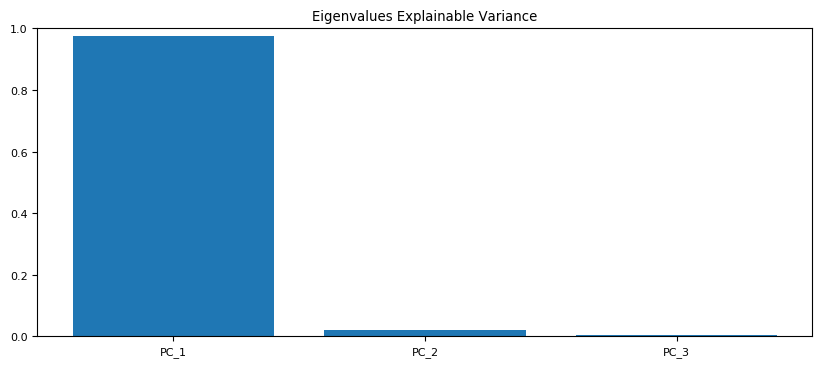

In [6]:
fig, ax = plt.subplots(figsize=(10,4))

ax.bar(
    eig_values.index[:pca_full.k], 
    eig_values["relative"][:pca_full.k]
)

ax.set_ylim(0,1)
ax.set_title ("Eigenvalues Explainable Variance")
plt.show()

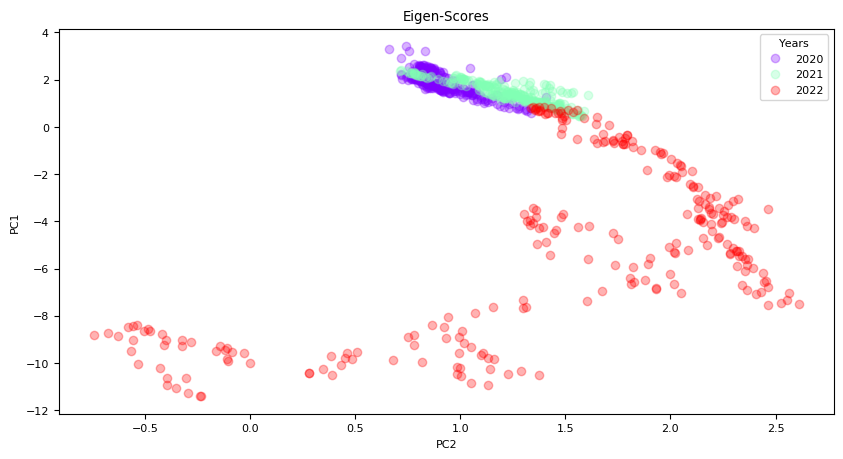

In [7]:
fig, ax = plt.subplots(figsize=(10,5))

color = rainbow(set(eig_scores.index.year))
eig_scores_by_year = eig_scores.groupby(eig_scores.index.year)

for year, data in eig_scores_by_year:
    ax.plot(
        data["PC_2"].values, 
        data["PC_1"].values, 
        c=color[year], 
        marker="o", 
        linestyle="", 
        alpha=0.3, 
        label=year
    )

ax.set_title("Eigen-Scores")
ax.set_ylabel("PC1")
ax.set_xlabel("PC2")
plt.legend(title="Years")
plt.show()

### Yield Curve Factors
***

In [8]:
eig_scores_scaled = std_scale_pandas(eig_scores)

# Classical yield curve factors
level = std_scale_pandas(df["10Y"])*-1
slope = std_scale_pandas(df["10Y"] - df["6M"])
curve = std_scale_pandas(df["6M"] + df["10Y"] - 2*df["5Y"])

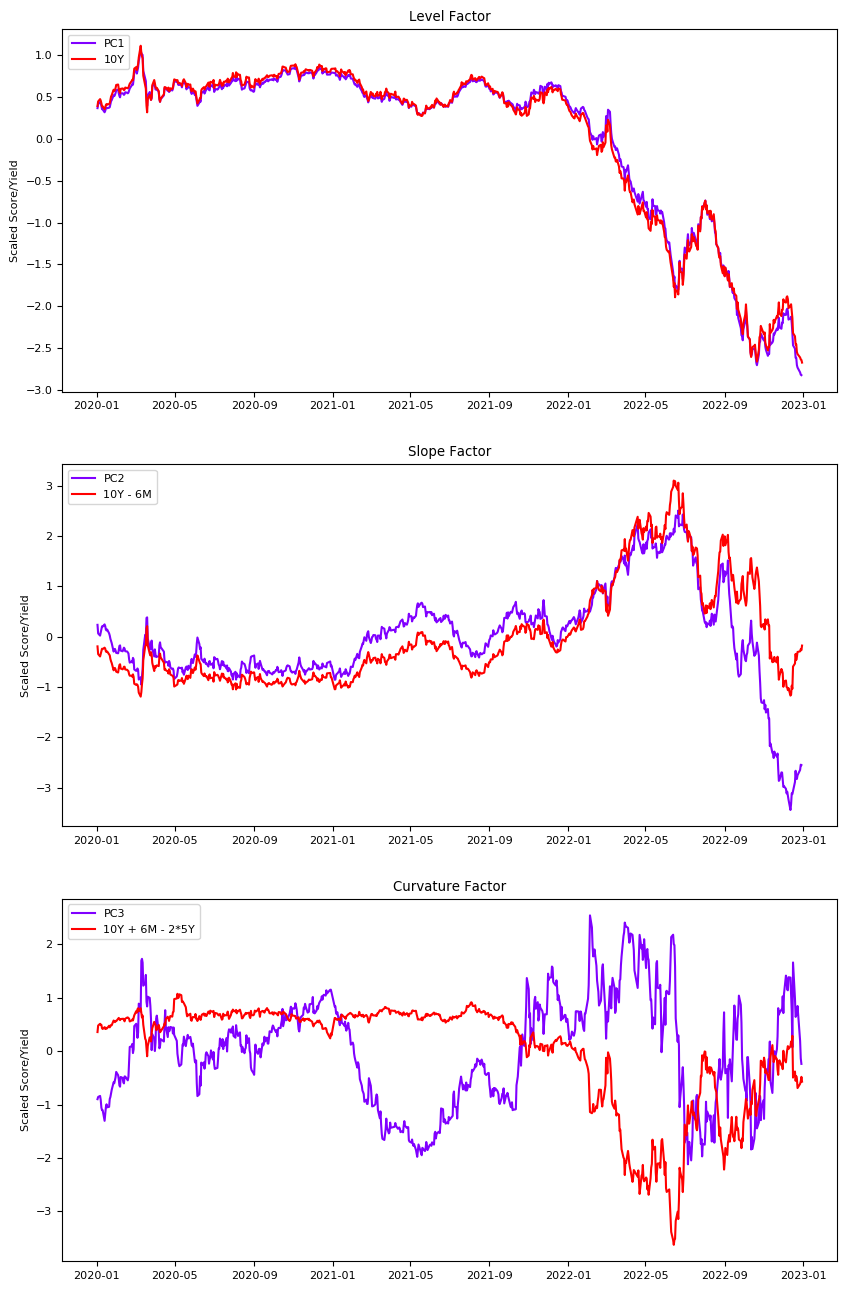

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,16))
colors = rainbow(["pca","actual"])

ax[0].plot(eig_scores_scaled["PC_1"], label="PC1", c=colors["pca"])
ax[1].plot(eig_scores_scaled["PC_2"], label="PC2", c=colors["pca"])
ax[2].plot(eig_scores_scaled["PC_3"], label="PC3", c=colors["pca"])

ax[0].plot(level, label="10Y", c=colors["actual"])
ax[1].plot(slope, label="10Y - 6M", c=colors["actual"])
ax[2].plot(curve, label="10Y + 6M - 2*5Y", c=colors["actual"])

ax[0].set_title ("Level Factor")
ax[1].set_title ("Slope Factor")
ax[2].set_title ("Curvature Factor")

for i in range (3):
    ax[i].set_ylabel ("Scaled Score/Yield")
    ax[i].legend(loc = "upper left")

plt.show()

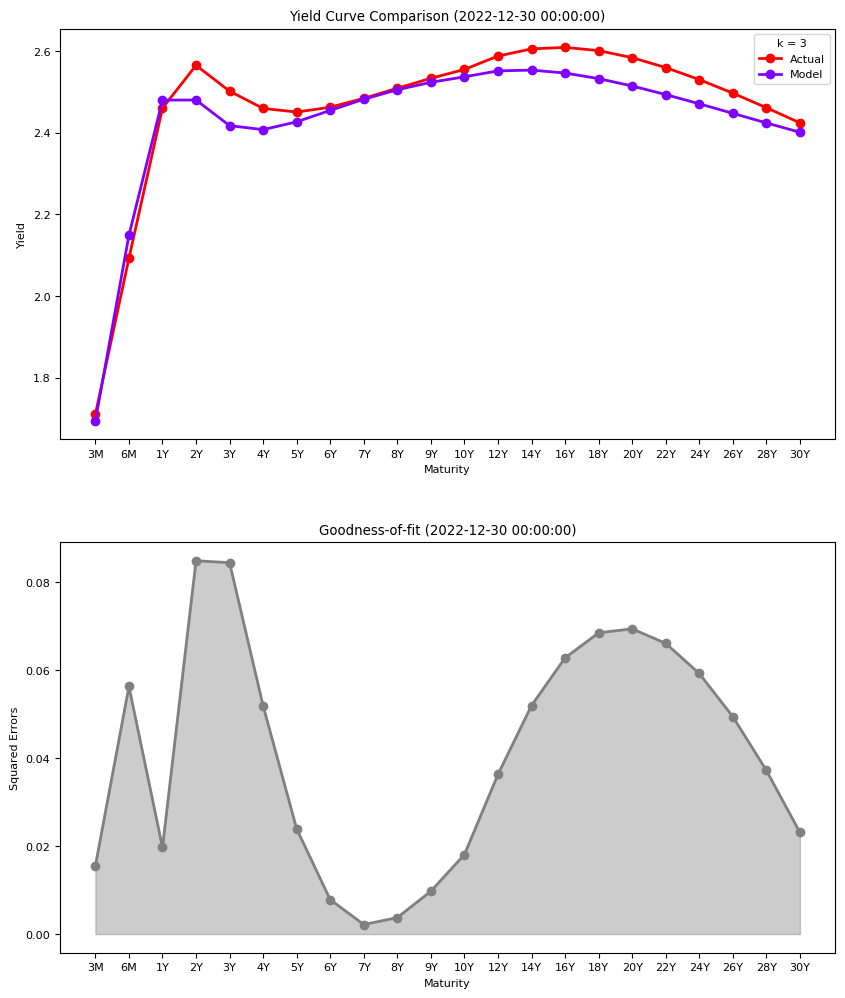

In [10]:
x = pca_rates.iloc[-1,:]
y = df.iloc[-1,:]
rse = np.sqrt((x-y)**2)

fig, ax = plt.subplots(nrows=2, figsize = (10,12))

ax[0].plot(y, label="Actual", c=colors["actual"], linewidth=2, marker="o")
ax[0].plot(x, label="Model",  c=colors["pca"], linewidth=2, marker="o")

ax[1].plot(rse, c="grey", linewidth=2, marker="o")
ax[1].fill_between(x.index, rse, color="grey", alpha=0.4)

ax[0].set_xlabel("Maturity")
ax[0].set_ylabel("Yield")
ax[0].set_title(f"Yield Curve Comparison ({df.index[-1]})")

ax[1].set_xlabel("Maturity")
ax[1].set_ylabel("Squared Errors")
ax[1].set_title(f"Goodness-of-fit ({df.index[-1]})")

ax[0].legend(title = "k = "+str(pca_full.k))
plt.subplots_adjust(hspace=0.25)
plt.show()

In [11]:
pca_rates_oos = PCA.get_backtrans_rates_oos(self=pca_train, df_test=df_test)

rmse_in_sample = calc_rmse(df, pca_rates)
rmse_out_sample = calc_rmse(df_test, pca_rates_oos)

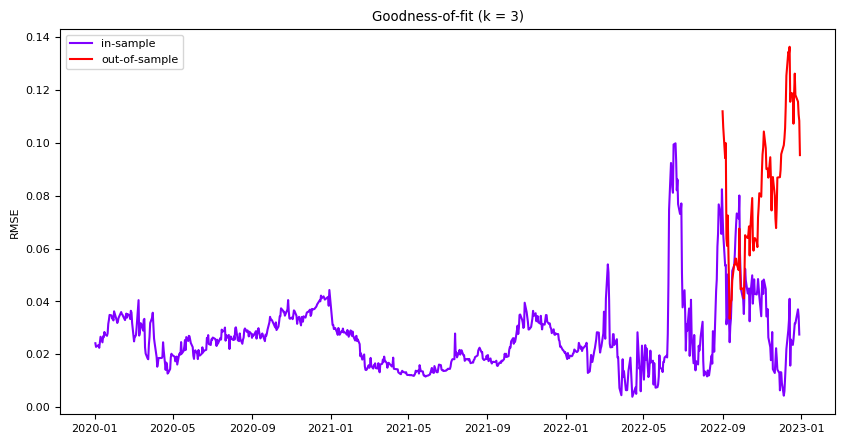

In [12]:
fig, ax = plt.subplots(figsize=(10,5))
color = rainbow(["in-sample","out-of-sample"])

ax.plot(rmse_in_sample, c=color["in-sample"], label="in-sample")
ax.plot(rmse_out_sample, c=color["out-of-sample"], label="out-of-sample")

ax.set_title ("Goodness-of-fit (k = "+ str(pca_full.k) + ")")
ax.set_ylabel ("RMSE")
ax.legend()

plt.show()